In [1]:
%cd /content
!mkdir /content/dataset
!mkdir /content/log
!mkdir /content/train
#
!git clone --branch main https://github.com/huggingface/diffusers
#
!pip install accelerate==0.32.1
!pip install datasets==2.19.1
!pip install ftfy==6.2.0
!pip install Jinja2==3.1.4
!pip install peft==0.11.1
!pip install tensorboard==2.15.2
!pip install torchvision==0.18.0+cu121
!pip install transformers==4.42.3
#
%cd /content/diffusers
!pip install -e .
#
!accelerate config
#
%cd /content/diffusers/examples/advanced_diffusion_training

/content
Cloning into 'diffusers'...
remote: Enumerating objects: 66553, done.
remote: Counting objects: 100% (1149/1149), done.
remote: Compressing objects: 100% (533/533), done.
remote: Total 66553 (delta 716), reused 871 (delta 521), pack-reused 65404
Receiving objects: 100% (66553/66553), 48.96 MiB | 18.50 MiB/s, done.
Resolving deltas: 100% (48919/48919), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 4.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_c

In [2]:
#LOAD IMAGES IN /content/drive/MyDrive/dataset

In [3]:
!accelerate launch --num_cpu_threads_per_process=1 /content/diffusers/examples/advanced_diffusion_training/train_dreambooth_lora_sd15_advanced.py \
  --adam_beta1=0.9 \
  --adam_beta2=0.999 \
  --adam_epsilon=1e-8 \
  --adam_weight_decay=0.01 \
  --checkpointing_steps=10 \
  --dataloader_num_workers=0 \
  --gradient_accumulation_steps=1 \
  --instance_data_dir="/content/dataset" \
  --instance_prompt="c4myl4" \
  --learning_rate=1e-4 \
  --logging_dir="/content/log" \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_grad_norm=1 \
  --max_train_steps=100 \
  --mixed_precision="fp16" \
  --output_dir="/content/train" \
  --pretrained_model_name_or_path="josemerinom/zero15" \
  --prior_loss_weight=1 \
  --rank=32 \
  --resolution=512 \
  --seed=0 \
  --train_batch_size=1 \
  --train_text_encoder \
  --optimizer="AdamW" \
  --text_encoder_lr=1e-4 \
  #

2024-07-05 12:28:06.386870: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-05 12:28:06.386919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-05 12:28:06.459824: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-05 12:28:06.467851: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-05 12:28:07.480527: W tensorflow/compiler/tf2

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!mv /content/train /content/drive/MyDrive

In [5]:
model_id="/content/drive/MyDrive/zero/rv51"
#
import torch
from diffusers import StableDiffusionPipeline
pipeline = StableDiffusionPipeline.from_pretrained(model_id, requires_safety_checker=False, safety_checker=None, feature_extractor = None, torch_dtype=torch.float16).to("cuda")
#
from diffusers import DPMSolverMultistepScheduler
pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config, use_karras_sigmas=True, final_sigmas_type="sigma_min")

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
#TEST NO LORA LOAD

IMG: 1 / SEED 1
a photo of a woman, close up face


  0%|          | 0/25 [00:00<?, ?it/s]

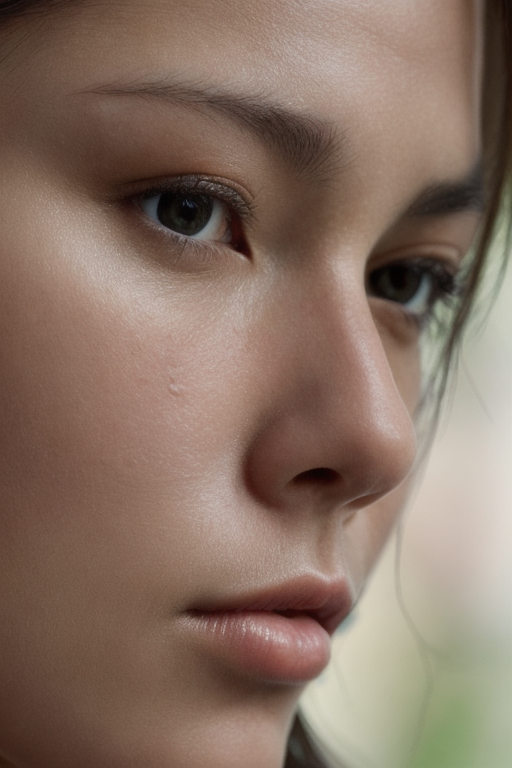

In [7]:
import torch
import random
from diffusers.utils import make_image_grid
from IPython.display import clear_output
#
images = []
n_img = 1
prompt="a photo of a woman, close up face"
negative=""
seed = 1
if seed == -1:
  seed=random.randint(0,999999999)
for i in range(0, n_img):
  clear_output()
  print(f"IMG: {i+1} / SEED {seed}")
  print(prompt)
  image=pipeline(prompt=prompt,negative_prompt=negative,width=512,height=768,num_inference_steps=25,guidance_scale=7,num_images_per_prompt=1,generator=torch.Generator("cuda").manual_seed(seed)).images[0]
  images.append(image)
  seed=seed+1
out_img = make_image_grid(images, rows=1, cols=n_img)
out_img

In [ ]:
#TEST LOAD LORA STEP 50

In [8]:
pipeline.unload_lora_weights()
pipeline.load_lora_weights("/content/drive/MyDrive/train/checkpoint-50/pytorch_lora_weights.safetensors")

IMG: 1 / SEED 1
c4myl4, a photo of a woman, close up face


  0%|          | 0/25 [00:00<?, ?it/s]

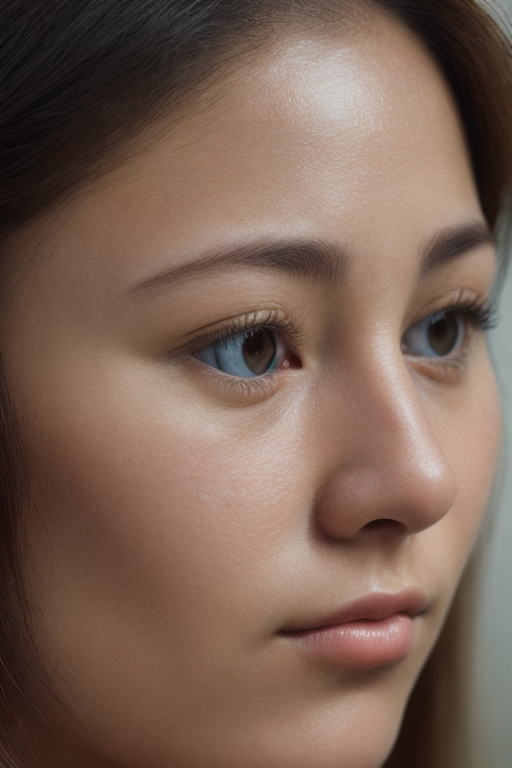

In [9]:
import torch
import random
from diffusers.utils import make_image_grid
from IPython.display import clear_output
#
images = []
n_img = 1
prompt="c4myl4, a photo of a woman, close up face"
negative=""
seed = 1
if seed == -1:
  seed=random.randint(0,999999999)
for i in range(0, n_img):
  clear_output()
  print(f"IMG: {i+1} / SEED {seed}")
  print(prompt)
  image=pipeline(prompt=prompt,negative_prompt=negative,width=512,height=768,num_inference_steps=25,guidance_scale=7,num_images_per_prompt=1,generator=torch.Generator("cuda").manual_seed(seed)).images[0]
  images.append(image)
  seed=seed+1
out_img = make_image_grid(images, rows=1, cols=n_img)
out_img

In [ ]:
#TEST LOAD LORA STEP 100

In [10]:
pipeline.unload_lora_weights()
pipeline.load_lora_weights("/content/drive/MyDrive/train/checkpoint-100/pytorch_lora_weights.safetensors")

IMG: 1 / SEED 1
c4myl4, a photo of a woman, close up face


  0%|          | 0/25 [00:00<?, ?it/s]

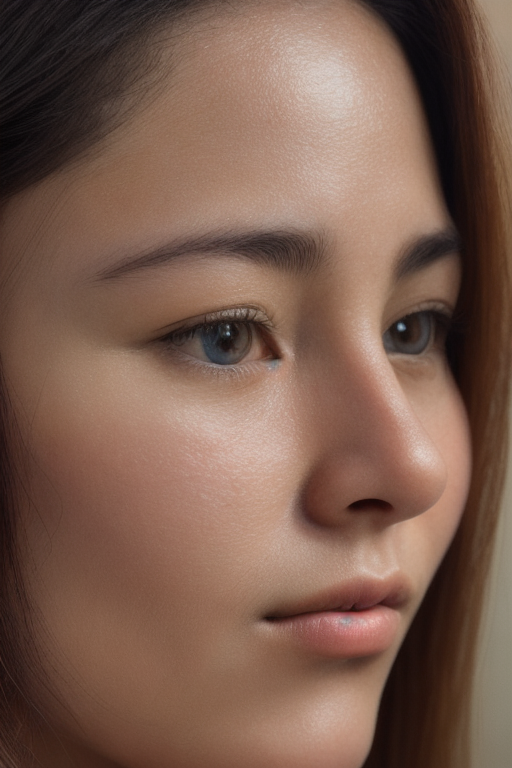

In [11]:
import torch
import random
from diffusers.utils import make_image_grid
from IPython.display import clear_output
#
images = []
n_img = 1
prompt="c4myl4, a photo of a woman, close up face"
negative=""
seed = 1
if seed == -1:
  seed=random.randint(0,999999999)
for i in range(0, n_img):
  clear_output()
  print(f"IMG: {i+1} / SEED {seed}")
  print(prompt)
  image=pipeline(prompt=prompt,negative_prompt=negative,width=512,height=768,num_inference_steps=25,guidance_scale=7,num_images_per_prompt=1,generator=torch.Generator("cuda").manual_seed(seed)).images[0]
  images.append(image)
  seed=seed+1
out_img = make_image_grid(images, rows=1, cols=n_img)
out_img